In [4]:
import pandas as pd
import zipfile
import os

# Đường dẫn đến file zip (bạn cần đảm bảo file này nằm đúng thư mục data/raw/)
zip_path = r'E:\btl\air_quality_timeseries_7\data\raw\PRSA2017_Data_20130301-20170228.zip'

def load_beijing_data(zip_path):
    """
    Hàm đọc tất cả các file CSV trong file zip PRSA2017 và gộp lại.
    """
    if not os.path.exists(zip_path):
        print(f"⚠️ Không tìm thấy file tại: {zip_path}")
        print("Vui lòng tải dataset từ UCI hoặc upload vào đúng thư mục.")
        return None

    data_frames = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Lọc ra các file .csv trong zip
        csv_files = [f for f in z.namelist() if f.endswith('.csv')]
        print(f"Tìm thấy {len(csv_files)} trạm đo.")
        
        for file in csv_files:
            with z.open(file) as f:
                df_temp = pd.read_csv(f)
                data_frames.append(df_temp)
    
    # Gộp tất cả thành 1 DataFrame lớn
    full_df = pd.concat(data_frames, axis=0, ignore_index=True)
    
    # Xử lý cột thời gian
    # Dataset này có các cột: year, month, day, hour -> cần ghép lại
    full_df['datetime'] = pd.to_datetime(full_df[['year', 'month', 'day', 'hour']])
    
    # Set index và sắp xếp
    full_df.set_index('datetime', inplace=True)
    full_df.sort_index(inplace=True)
    
    print(f"✓ Đã load xong. Kích thước: {full_df.shape}")
    return full_df

# --- SỬ DỤNG ---
df_all = load_beijing_data(zip_path)

if df_all is not None:
    # Chọn một trạm cụ thể để phân tích (Ví dụ: trạm Aotizhongxin)
    # Vì ARIMA thường chạy trên 1 chuỗi thời gian đơn lẻ
    target_station = 'Aotizhongxin' 
    df = df_all[df_all['station'] == target_station].copy()
    
    # Chọn cột mục tiêu PM2.5
    df = df[['PM2.5']].copy()
    
    # Xử lý nhanh dữ liệu thiếu cho demo (thực tế cần impute kỹ hơn)
    df = df.fillna(method='ffill')
    
    print(f"Dữ liệu sẵn sàng cho phân tích trạm {target_station}: {df.shape}")
    
    # BÂY GIỜ BẠN CÓ THỂ CHẠY TIẾP CÁC PHẦN VẼ BIỂU ĐỒ (Q1, Q2, Q3) Ở TRÊN

Tìm thấy 12 trạm đo.
✓ Đã load xong. Kích thước: (420768, 18)
Dữ liệu sẵn sàng cho phân tích trạm Aotizhongxin: (35064, 1)


C:\Users\III\AppData\Local\Temp\ipykernel_1592\1332476542.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


C:\Users\III\AppData\Local\Temp\ipykernel_1592\423197880.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start='2016-01-01', end='2016-03-31 23:00:00', freq='H')


All images generated.


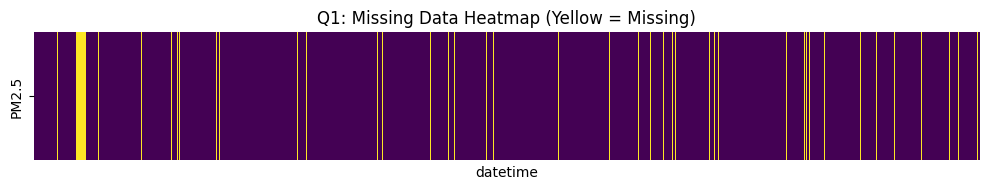

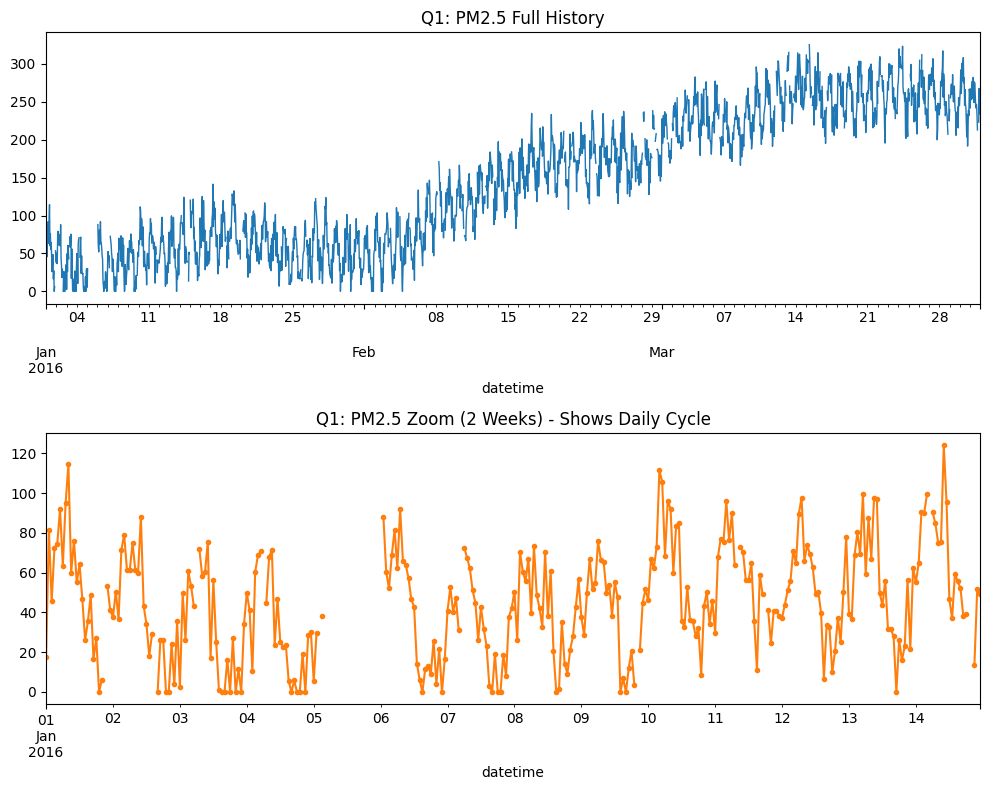

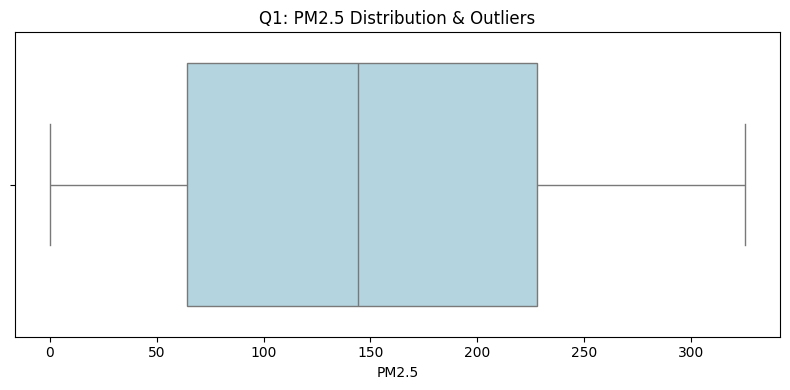

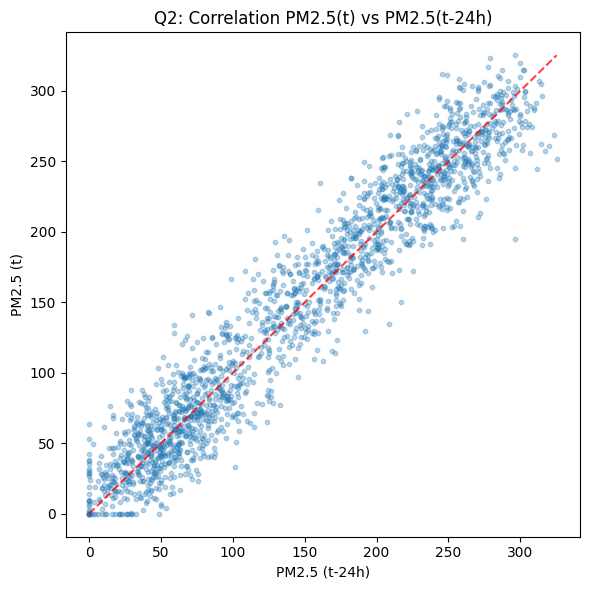

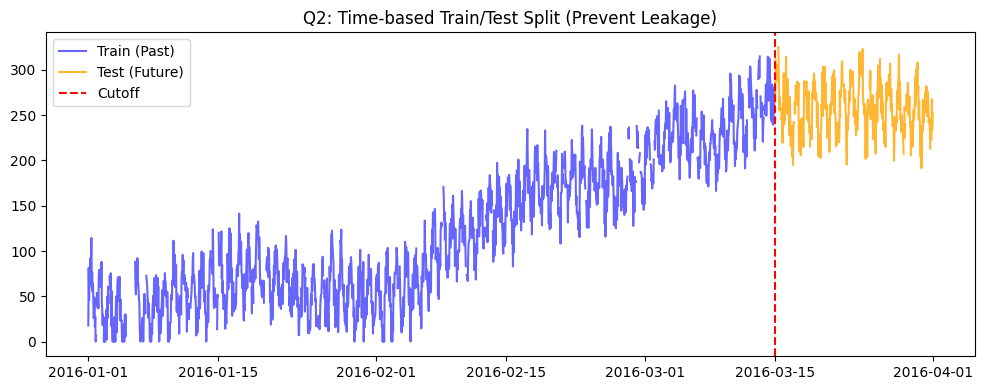

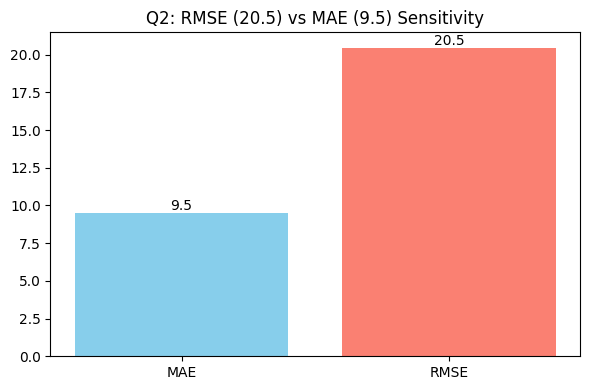

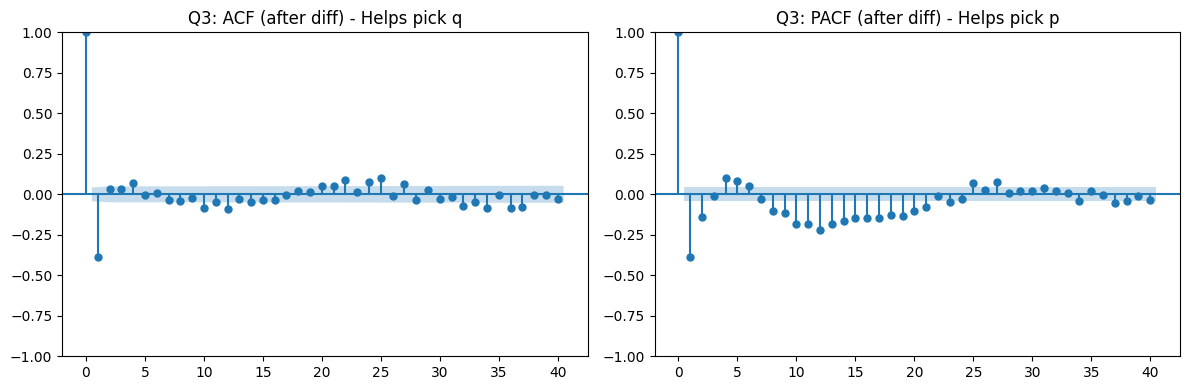

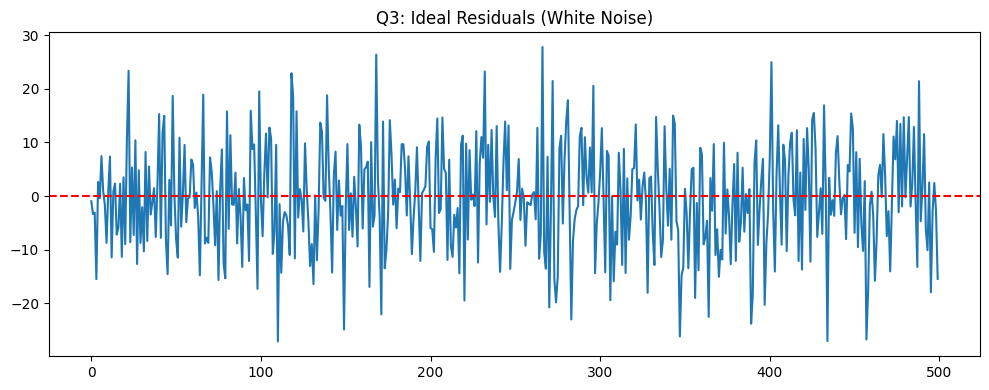

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. GENERATE SYNTHETIC DATA ---
np.random.seed(42)
dates = pd.date_range(start='2016-01-01', end='2016-03-31 23:00:00', freq='H')
n = len(dates)

# Signal: Daily cycle (period=24) + Weekly trend + Random Walk + Noise
daily_seasonality = 30 * np.sin(2 * np.pi * np.arange(n) / 24)
trend = np.linspace(0, 50, n) + np.cumsum(np.random.normal(0, 2, n))
noise = np.random.normal(0, 15, n)
pm25 = 50 + daily_seasonality + trend + noise
pm25 = np.maximum(pm25, 0) # PM2.5 >= 0

df = pd.DataFrame({'datetime': dates, 'PM2.5': pm25})
df.set_index('datetime', inplace=True)

# Introduce Missing Values (Gap & Scattered)
df.iloc[100:120, 0] = np.nan # Gap
mask = np.random.choice([True, False], size=n, p=[0.05, 0.95]) # Scattered
df.loc[mask, 'PM2.5'] = np.nan

# --- Q1: DATA UNDERSTANDING VISUALIZATIONS ---

# 1.1 Missing Data Heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(df.isnull().T, cbar=False, cmap='viridis', xticklabels=False)
plt.title('Q1: Missing Data Heatmap (Yellow = Missing)')
plt.tight_layout()
plt.savefig('q1_missing_heatmap.png')

# 1.2 Time Series Plot (Full + Zoom)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
df['PM2.5'].plot(ax=ax[0], title='Q1: PM2.5 Full History', color='#1f77b4', lw=1)
df['PM2.5'].iloc[:24*14].plot(ax=ax[1], title='Q1: PM2.5 Zoom (2 Weeks) - Shows Daily Cycle', color='#ff7f0e', lw=1.5, marker='.')
plt.tight_layout()
plt.savefig('q1_timeseries.png')

# 1.3 Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['PM2.5'].dropna(), color='lightblue')
plt.title('Q1: PM2.5 Distribution & Outliers')
plt.tight_layout()
plt.savefig('q1_boxplot.png')

# --- Q2: REGRESSION BASELINE VISUALIZATIONS ---

# 2.1 Correlation with Lag 24
df_lag = df.copy()
df_lag['PM2.5_Lag24'] = df_lag['PM2.5'].shift(24)
plt.figure(figsize=(6, 6))
plt.scatter(df_lag['PM2.5_Lag24'], df_lag['PM2.5'], alpha=0.3, s=10)
plt.title('Q2: Correlation PM2.5(t) vs PM2.5(t-24h)')
plt.xlabel('PM2.5 (t-24h)')
plt.ylabel('PM2.5 (t)')
# Add y=x line
lims = [0, max(df_lag['PM2.5'].max(), df_lag['PM2.5_Lag24'].max())]
plt.plot(lims, lims, 'r--', alpha=0.75)
plt.tight_layout()
plt.savefig('q2_lag_correlation.png')

# 2.2 Train/Test Split Visualization
cutoff = '2016-03-15'
train = df.loc[df.index < cutoff]
test = df.loc[df.index >= cutoff]

plt.figure(figsize=(10, 4))
plt.plot(train.index, train['PM2.5'], label='Train (Past)', color='blue', alpha=0.6)
plt.plot(test.index, test['PM2.5'], label='Test (Future)', color='orange', alpha=0.8)
plt.axvline(pd.to_datetime(cutoff), color='red', linestyle='--', label='Cutoff')
plt.title('Q2: Time-based Train/Test Split (Prevent Leakage)')
plt.legend()
plt.tight_layout()
plt.savefig('q2_split.png')

# 2.3 RMSE vs MAE Demo
# Simulate a prediction with spikes errors
y_true = np.array([10, 20, 15, 100, 12, 15]) # 100 is a spike
y_pred = np.array([12, 18, 14, 50,  13, 14]) # Predicted 50 instead of 100 (large error)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

plt.figure(figsize=(6, 4))
bars = plt.bar(['MAE', 'RMSE'], [mae, rmse], color=['skyblue', 'salmon'])
plt.title(f'Q2: RMSE ({rmse:.1f}) vs MAE ({mae:.1f}) Sensitivity')
plt.bar_label(bars, fmt='%.1f')
plt.tight_layout()
plt.savefig('q2_rmse_mae.png')


# --- Q3: ARIMA DIAGNOSTICS VISUALIZATIONS ---

# 3.1 ACF & PACF
clean_series = df['PM2.5'].dropna()
# Diff to make stationary for PACF visualization usually
diff_series = clean_series.diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff_series, lags=40, ax=ax[0], title='Q3: ACF (after diff) - Helps pick q')
plot_pacf(diff_series, lags=40, ax=ax[1], title='Q3: PACF (after diff) - Helps pick p')
plt.tight_layout()
plt.savefig('q3_acf_pacf.png')

# 3.2 Residuals (White Noise check)
# Simulate residuals from a good model (normal dist)
residuals = np.random.normal(0, 10, 500)
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Q3: Ideal Residuals (White Noise)')
plt.tight_layout()
plt.savefig('q3_residuals.png')

print("All images generated.")